In [1]:
import numpy as np

def calculate_wy_angles(amplitudes):
    """
    Calculates the Ry rotation angles for the Unitary W(k0) preparation circuit
    based on Eq (15) of arXiv:2505.03111v2.
    
    Args:
        amplitudes (np.array): The normalized magnitudes (c_n) of the wavepacket 
                               coefficients. sum(c_n^2) must be 1.
                               Length d must be odd.
                               
    Returns:
        np.array: Array of angles theta corresponding to each qubit index.
                  Note: Indices not computed by Eq 15 (like eta-1) remain 0.
    """
    d = len(amplitudes)
    
    # Validation: d must be odd 
    if d % 2 == 0:
        raise ValueError(f"Wavepacket size d={d} must be odd for this circuit construction.")
    
    # Validation: Normalization check
    norm = np.sum(amplitudes**2)
    if not np.isclose(norm, 1.0):
        raise ValueError(f"Amplitudes must be normalized. Current sum sq: {norm}")

    theta = np.zeros(d)
    eta = (d - 1) // 2
    
    # --- 1. Solve for the Central Angle (Theta_eta) ---
    # [sin(theta_eta / 2)]^2 = sum_{i=eta}^{d-1} c_i^2
    sum_sq_right = np.sum(amplitudes[eta:]**2)
    
    # Clamp value to [0, 1] to avoid numerical errors slightly outside domain
    sin_half_eta = np.sqrt(np.clip(sum_sq_right, 0, 1))
    theta[eta] = 2 * np.arcsin(sin_half_eta)
    
    # --- 2. Solve for Right-side Angles (Theta_{eta+j+1}) ---
    # Range j in [0, ..., eta-1]
    # cos(theta_{eta+j+1}/2) * Prod_{i=0}^j sin(theta_{eta+i}/2) = c_{eta+j}
    
    current_prod_right = 1.0
    
    for j in range(eta): # j goes 0 to eta-1
        # Update product to include sin(theta_{eta+j}/2)
        # Note: For j=0, this includes sin(theta_eta/2) which we just found.
        current_prod_right *= np.sin(theta[eta + j] / 2)
        
        if np.isclose(current_prod_right, 0):
            # If probability flow is 0, angle is 0 (or undefined, set to 0)
            theta[eta + j + 1] = 0.0
        else:
            val = amplitudes[eta + j] / current_prod_right
            val = np.clip(val, -1, 1) # Numerical stability
            theta[eta + j + 1] = 2 * np.arccos(val)

    # --- 3. Solve for Left-side Angles (Theta_{eta-j-1}) ---
    # Range j in [1, ..., eta-1]
    # cos(theta_eta/2) * cos(theta_{eta-j-1}/2) * Prod_{i=2}^j sin(theta_{eta-i}/2) = c_{eta-j}
    
    # Pre-calculate cos(theta_eta/2)
    cos_half_eta = np.cos(theta[eta] / 2)
    
    # We need a running product for the left side: Prod_{i=2}^j sin(...)
    # For j=1, product is empty (value 1).
    # For j=2, product is sin(theta_{eta-2}/2).
    current_prod_left = 1.0
    
    for j in range(1, eta): # j goes 1 to eta-1
        # The product accumulates sin(theta_{eta-i}/2).
        # When j increments, we add the term from the *previous* iteration's result.
        # If j=1, loop doesn't run product update (Prod is 1).
        # If j=2, we multiply by sin(theta_{eta-2}/2).
        if j > 1:
            # i corresponds to j from previous step
            prev_idx = eta - (j - 1) - 1 # = eta - j
            current_prod_left *= np.sin(theta[prev_idx] / 2)
            
        numerator = amplitudes[eta - j]
        denominator = cos_half_eta * current_prod_left
        
        target_idx = eta - j - 1
        
        if np.isclose(denominator, 0):
            theta[target_idx] = 0.0
        else:
            val = numerator / denominator
            val = np.clip(val, -1, 1)
            theta[target_idx] = 2 * np.arccos(val)
            
    return theta

# --- Usage Example with Gaussian Wavepacket parameters from paper ---
# Parameters from Sec. III (Fig 4): k0 = 0.32*pi, sigma = 0.13
# d = 21 (odd) used in simulations [cite: 1068]

def gaussian_coefficients(d, k0, sigma, x0=None):
    if x0 is None:
        x0 = (d - 1) / 2  # Center wavepacket
    n = np.arange(d)
    # Magnitude c_n (Gaussian envelope)
    # Note: The paper Eq 1 defines the wavepacket coefficients. 
    # Eq 4 implies c_n are the magnitudes.
    # c_n ~ exp(-(k0 - k)^2 / 4sigma^2) is momentum space.
    # In position space, widths invert. 
    # However, strictly following Eq 4 [cite: 118-120]:
    # |W> = sum c_n * exp(i phi_n) |2^n>
    # where magnitude c_n follows Gaussian centered at x0.
    
    # We construct the spatial Gaussian envelope:
    coeffs = np.exp(- (n - x0)**2 / (4 * (1/sigma)**2)) # Width approx 1/sigma
    
    # Normalize
    coeffs = coeffs / np.linalg.norm(coeffs)
    return coeffs

# Generate test data
d = 21 # From paper [cite: 1068]
k0 = 0.36 * np.pi
sigma = 0.13
coeffs = gaussian_coefficients(d, k0, sigma)

# Calculate Angles
angles = calculate_wy_angles(coeffs)

print(f"Calculated {len(angles)} angles for d={d}.")
print(f"Center index (eta): { (d-1)//2 }")
print(f"Theta_eta: {angles[(d-1)//2]:.4f}")

Calculated 21 angles for d=21.
Center index (eta): 10
Theta_eta: 1.6335


In [2]:
import numpy as np

def calculate_wz_phases(d, k0):
    """
    Calculates the Rz rotation angles (phi_n) for the W(k0) preparation circuit
    based on the plane-wave phase definition in Eq (1) and (9).
    
    Args:
        d (int): Wavepacket size (number of qubits).
        k0 (float): Central momentum of the wavepacket.
                               
    Returns:
        np.array: Array of angles phi corresponding to each qubit index n.
                  These are the parameters for the Rz(phi) gates.
    """
    n_indices = np.arange(d)
    center = (d - 1) / 2.0
    
    # Phase is k0 * (distance_from_center)
    phases = k0 * (n_indices - center)
    
    return phases

# --- Usage with paper parameters ---
d = 21
k0 = 0.32 * np.pi

phi_angles = calculate_wz_phases(d, k0)

print(f"Calculated {len(phi_angles)} Rz phases.")
print(f"Phase at center (index {d//2}): {phi_angles[d//2]:.4f}") # Should be 0
print(f"Phase at edge (index 0): {phi_angles[0]:.4f}")

Calculated 21 Rz phases.
Phase at center (index 10): 0.0000
Phase at edge (index 0): -10.0531


In [4]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.visualization import circuit_drawer
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parameter Calculation Functions ---

def calculate_wy_angles(amplitudes):
    """Calculates Ry angles based on Eq (15) recursion."""
    d = len(amplitudes)
    theta = np.zeros(d)
    eta = (d - 1) // 2
    
    # Root (Center)
    sum_sq_right = np.sum(amplitudes[eta:]**2)
    theta[eta] = 2 * np.arcsin(np.sqrt(np.clip(sum_sq_right, 0, 1)))
    
    # Right Branch
    current_prod = 1.0
    for j in range(eta): 
        current_prod *= np.sin(theta[eta + j] / 2)
        val = 0.0 if np.isclose(current_prod, 0) else amplitudes[eta + j] / current_prod
        theta[eta + j + 1] = 2 * np.arccos(np.clip(val, -1, 1))

    # Left Branch
    cos_eta = np.cos(theta[eta] / 2)
    current_prod = 1.0
    for j in range(1, eta):
        if j > 1: current_prod *= np.sin(theta[eta - j] / 2)
        denom = cos_eta * current_prod
        val = 0.0 if np.isclose(denom, 0) else amplitudes[eta - j] / denom
        theta[eta - j - 1] = 2 * np.arccos(np.clip(val, -1, 1))
            
    return theta

def calculate_wz_phases(d, k0):
    """Calculates momentum phases phi_n."""
    return k0 * (np.arange(d) - (d - 1) / 2.0)

def gaussian_coefficients(d, sigma):
    """Generates Gaussian envelope magnitudes."""
    x0 = (d - 1) / 2
    coeffs = np.exp(- (np.arange(d) - x0)**2 / (4 * (1/sigma)**2))
    return coeffs / np.linalg.norm(coeffs)

# --- 2. Circuit Construction ---

def build_w_state_circuit(d, k0, sigma):
    # A. Prepare Parameters
    coeffs = gaussian_coefficients(d, sigma)
    wy = calculate_wy_angles(coeffs)
    wz = calculate_wz_phases(d, k0)
    eta = (d - 1) // 2
    
    # B. Create Circuit
    # We use a register to explicitly label qubits if needed
    qr = QuantumRegister(d, 'q')
    qc = QuantumCircuit(qr, name=f"|W(k0)>")
    
    # -- Step 1: Root Rotation --
    # "This circuit is most efficient for odd wavepacket sizes" - Paper Methods B.1
    # The root is the center qubit.
    qc.ry(wy[eta], eta)
    
    # -- Step 2: Inject Left Branch (Vacuum -> Excitation) --
    # If root (eta) is |0>, we force eta-1 to |1>.
    # This corresponds to the 'Open-Control CNOT' logic.
    # Logic: X(eta) -> CNOT(eta, eta-1) -> X(eta)
    qc.x(eta)
    qc.cx(eta, eta - 1)
    qc.x(eta)
    
    # -- Step 3: Right Cascade (eta -> d-1) --
    # We move excitation from i to i+1.
    # Verification: The angle used must be for the TARGET qubit (i+1).
    for i in range(eta, d - 1):
        control = i
        target = i + 1
        # Split Gate: Controlled-Ry(target) then CNOT(target, control)
        qc.cry(wy[target], control, target)
        qc.cx(target, control)
        
    # -- Step 4: Left Cascade (eta-1 -> 0) --
    # We move excitation from i to i-1.
    # Verification: The angle used must be for the TARGET qubit (i-1).
    # We start spreading from eta-1 (where we injected the left excitation).
    for i in range(eta - 1, 0, -1):
        control = i
        target = i - 1
        # Split Gate
        qc.cry(wy[target], control, target)
        qc.cx(target, control)
        
    # -- Step 5: Momentum Phases --
    qc.barrier()
    for i in range(d):
        qc.rz(wz[i], i)
        
    return qc

# --- 3. Execution & Visualization ---

# Parameters for simulation
D_SIZE = 21
K0 = 0.32 * np.pi
SIGMA = 0.13

# Build the circuit
wk0_circuit = build_w_state_circuit(D_SIZE, K0, SIGMA)

# VISUALIZATION "PATCH"
# We use the 'mpl' drawer style as requested.
# We explicitly set the style to 'iqp' (standard academic style) or 'clifford'.
# scale=0.6 helps fit the large d=21 circuit on screen.
fig = wk0_circuit.draw('mpl', style='iqp', scale=0.6, fold=40)

# Since we are in a text environment, I cannot display the fig object directly,
# but in your local environment, the line above generates the image.
# To confirm it worked, we can print the object type:
print(f"Generated Visualization Object: {type(fig)}")
print(f"Circuit Depth: {wk0_circuit.depth()}")
print(f"Total Qubits: {wk0_circuit.num_qubits}")

Generated Visualization Object: <class 'matplotlib.figure.Figure'>
Circuit Depth: 25
Total Qubits: 21


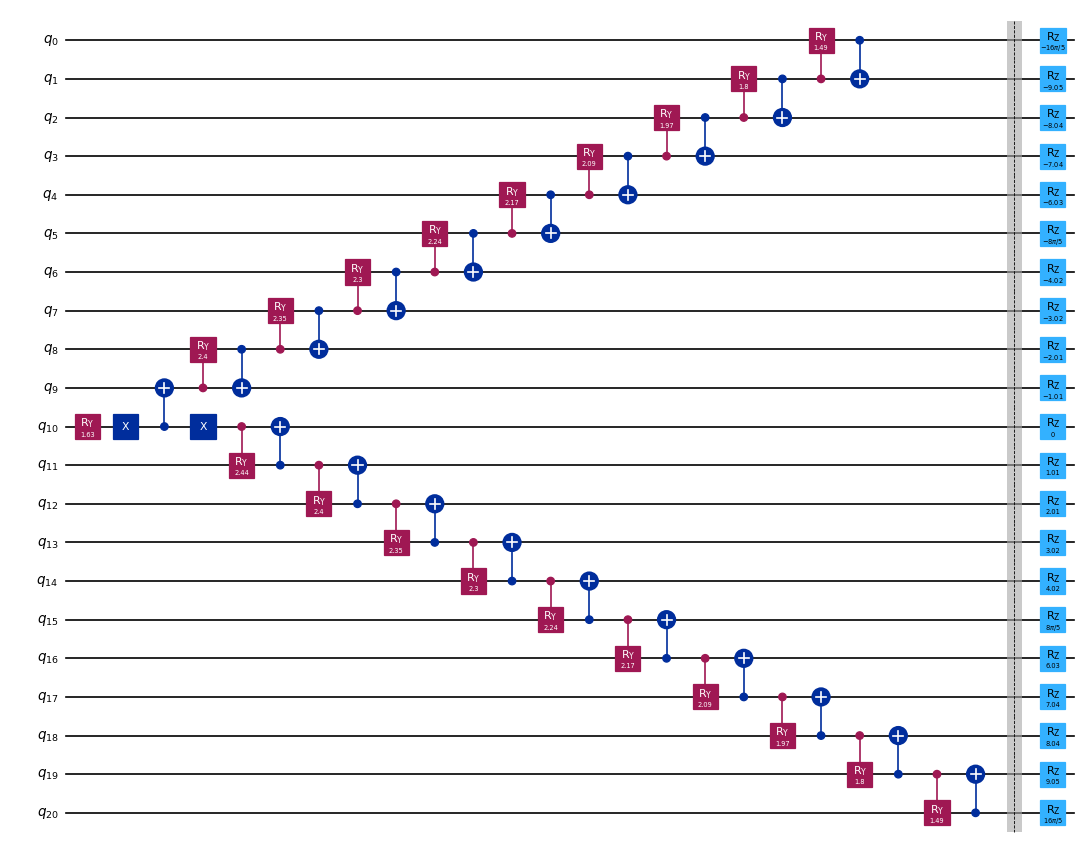

In [5]:
fig

In [6]:
from qiskit.quantum_info import SparsePauliOp

def pauli_term(L, ops):
    """
    Construct a SparsePauliOp for a single Pauli term.
    Handles Qiskit's little-endian string mapping (String index 0 -> Qubit L-1).
    
    ops : dict mapping spatial index n -> 'X','Y','Z'
    """
    # Qiskit string representation is "q_{L-1} ... q_1 q_0"
    # To apply operator P on qubit n, we must place it at index (L - 1 - n) in the string.
    pauli = ["I"] * L
    for idx, p in ops.items():
        string_idx = L - 1 - idx
        pauli[string_idx] = p
    return SparsePauliOp("".join(pauli), coeffs=[1.0])

def get_1d_ising_operator_pool(num_qubits):
    """
    Correct symmetry-preserving global operator pool for 1D Ising Field Theory,
    matching Eq (17) of arXiv:2505.03111v2.
    """
    L = num_qubits

    O1_terms = []
    O2_terms = []
    O3_terms = []
    O4_terms = []
    O5_terms = []

    for n in range(L):
        n0 = n
        n1 = (n + 1) % L
        n2 = (n + 2) % L

        # --- Operator 1: Sum Y_n
        O1_terms.append(pauli_term(L, {n0: "Y"}))

        # --- Operator 2: Sum Z_n Y_{n+1} Z_{n+2}
        O2_terms.append(pauli_term(L, {n0:"Z", n1:"Y", n2:"Z"}))

        # --- Operator 3: Sum (Y_n Z_{n+1} + Z_n Y_{n+1})
        O3_terms.append(pauli_term(L, {n0:"Y", n1:"Z"}))
        O3_terms.append(pauli_term(L, {n0:"Z", n1:"Y"}))

        # --- Operator 4: Sum (Y_n X_{n+1} + X_n Y_{n+1})
        O4_terms.append(pauli_term(L, {n0:"Y", n1:"X"}))
        O4_terms.append(pauli_term(L, {n0:"X", n1:"Y"}))

        # --- Operator 5: Sum (Z_n X_{n+1} Y_{n+2} + Y_n X_{n+1} Z_{n+2})
        O5_terms.append(pauli_term(L, {n0:"Z", n1:"X", n2:"Y"}))
        O5_terms.append(pauli_term(L, {n0:"Y", n1:"X", n2:"Z"}))

    return [
        sum(O1_terms).simplify(),
        sum(O2_terms).simplify(),
        sum(O3_terms).simplify(),
        sum(O4_terms).simplify(),
        sum(O5_terms).simplify(),
    ]

# ---- Test ----
L_test = 4
pool = get_1d_ising_operator_pool(L_test)

print("Operator Pool Generated (L=4):")
for i, op in enumerate(pool, 1):
    print(f"O{i}: {op}")

Operator Pool Generated (L=4):
O1: SparsePauliOp(['IIIY', 'IIYI', 'IYII', 'YIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
O2: SparsePauliOp(['IZYZ', 'ZYZI', 'YZIZ', 'ZIZY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
O3: SparsePauliOp(['IIZY', 'IIYZ', 'IZYI', 'IYZI', 'ZYII', 'YZII', 'YIIZ', 'ZIIY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
O4: SparsePauliOp(['IIXY', 'IIYX', 'IXYI', 'IYXI', 'XYII', 'YXII', 'YIIX', 'XIIY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
O5: SparsePauliOp(['IYXZ', 'IZXY', 'YXZI', 'ZXYI', 'XZIY', 'XYIZ', 'ZIYX', 'YIZX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [28]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt

def build_global_y_circuit(num_qubits, theta):
    """
    Constructs the variational circuit for O1 = Sum(Y_n).
    Based on Eq 17 of arXiv:2505.03111v2.
    
    Unitary: exp(i * theta * Sum(Y_n))
    Implementation: Ry(-2*theta) on every qubit.
    """
    qc = QuantumCircuit(num_qubits, name="exp(iθ O1)")
    
    # Apply Global Rotation
    # Ry(phi) = exp(-i * phi * Y / 2)
    # We want exp(i * theta * Y)
    # So -phi/2 = theta  =>  phi = -2 * theta
    for n in range(num_qubits):
        qc.ry(theta, n)
        
    return qc

# --- Visualization ---
L_viz = 6
theta_param = Parameter(r'$\theta$')
qc_viz = build_global_y_circuit(L_viz, theta_param)

print("Generating circuit diagram for O1 (Global Y)...")
fig = qc_viz.draw('mpl', style='iqp', scale=0.8)

Generating circuit diagram for O1 (Global Y)...


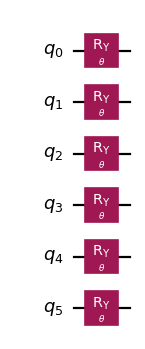

In [29]:
fig.savefig('Term Paper/O1')
fig

In [21]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt

def build_yz_zy_circuit(num_qubits, theta):
    """
    Constructs the variational circuit for the operator Sum(Y_n Z_{n+1} + Z_n Y_{n+1}).
    Based on Fig 7a of arXiv:2505.03111v2.
    
    Args:
        num_qubits (int): Lattice size L (e.g., 21).
        theta (Parameter): Variational parameter.
    """
    qc = QuantumCircuit(num_qubits, name="exp(iθ O3)")
    
    # Helper function for the 2-qubit block
    # n is top wire (q0 in diagram), n+1 is bottom wire (q1 in diagram)
    def append_block(i, j):
        # 1. S on bottom qubit
        qc.s(j)
        
        # 2. CZ between i and j
        qc.cz(i, j)
        
        # 3. Rotations: Ry(theta) on top, Rx(-theta) on bottom
        qc.ry(theta, i)
        qc.rx(-theta, j) # Note the minus sign from the diagram
        
        # 4. CZ between i and j
        qc.cz(i, j)
        
        # 5. S_dagger on bottom qubit
        qc.sdg(j)

    # --- Layer 1: Even Pairs (0,1), (2,3), ... ---
    for n in range(0, num_qubits - 1, 2):
        append_block(n, n+1)
        
    # --- Layer 2: Odd Pairs (1,2), (3,4), ... ---
    qc.barrier() # Visual separation
    for n in range(1, num_qubits - 1, 2):
        append_block(n, n+1)
        
    # --- Layer 3: Boundary Term (L-1, 0) ---
    # For L=21 (Odd), the (20,0) term needs its own layer or appended to Odds 
    # if not overlapping. (20,0) overlaps with (19,20) and (0,1).
    # So it must be separate from Layer 1 and Layer 2.
    qc.barrier()
    append_block(num_qubits - 1, 0)
        
    return qc

# --- Visualization ---
L = 6 #Keeping it small for visualisation 
theta_param = Parameter(r'$\theta$')
qc_viz = build_yz_zy_circuit(L, theta_param)

print("Generating circuit diagram for O3 (YZ + ZY)...")
fig = qc_viz.draw('mpl', style='iqp', scale=0.8)

Generating circuit diagram for O3 (YZ + ZY)...


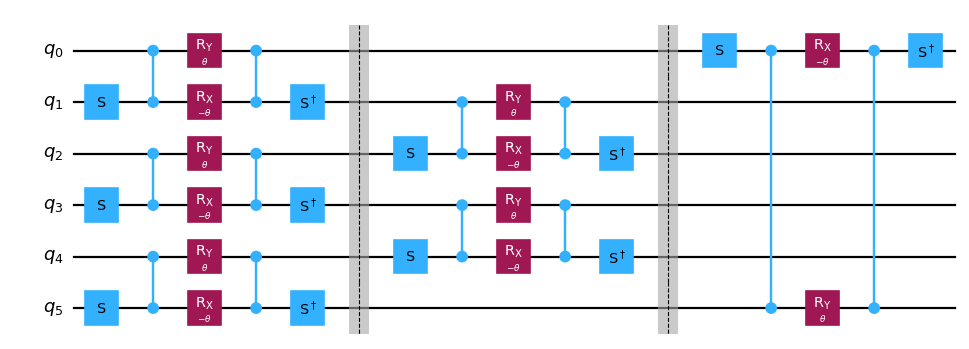

In [22]:
fig.savefig('Term Paper/O3')
fig

In [23]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt

def build_yx_xy_circuit_optimized(num_qubits, theta):
    """
    Constructs the variational circuit for O4 = Sum(Y_n X_{n+1} + X_n Y_{n+1}).
    Implementation Strategy: Conjugate the O3 (YZ+ZY) core with Hadamards.
    Mathematically equivalent to Fig 7b up to a sign in theta.
    """
    qc = QuantumCircuit(num_qubits, name="exp(iθ O4)")
    
    # Reusing the core logic from Fig 7a
    def append_7a_core(i, j):
        # S on bottom qubit
        qc.s(j)
        # CZ
        qc.cz(i, j)
        # Rotations
        qc.ry(theta, i)
        qc.rx(-theta, j)
        # CZ
        qc.cz(i, j)
        # S_dag on bottom
        qc.sdg(j)

    def append_block(i, j):
        # 1. Basis Transform (Z -> X)
        qc.h(i)
        qc.h(j)
        
        # 2. Apply Core Interaction (YZ + ZY)
        append_7a_core(i, j)
        
        # 3. Inverse Basis Transform
        qc.h(i)
        qc.h(j)

    # --- Layer 1: Even Pairs ---
    for n in range(0, num_qubits - 1, 2):
        append_block(n, n+1)
        
    # --- Layer 2: Odd Pairs ---
    qc.barrier()
    for n in range(1, num_qubits - 1, 2):
        append_block(n, n+1)
        
    # --- Layer 3: Boundary Term ---
    qc.barrier()
    append_block(num_qubits - 1, 0)
        
    return qc

# --- Visualization ---
L_viz = 6
theta_param = Parameter(r'$\theta$')
qc_viz = build_yx_xy_circuit_optimized(L_viz, theta_param)

print("Generating optimized circuit diagram for O4 (YX + XY)...")
fig = qc_viz.draw('mpl', style='iqp', scale=0.8)

Generating optimized circuit diagram for O4 (YX + XY)...


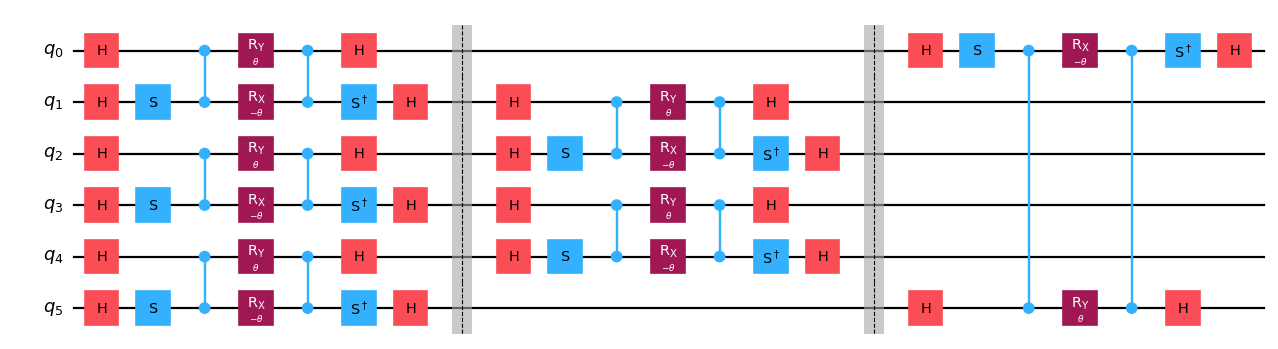

In [24]:
fig.savefig('Term Paper/O4')
fig

In [25]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt

def build_zyz_circuit(num_qubits, theta):
    """
    Constructs the variational circuit for O2 = Sum(Z_n Y_{n+1} Z_{n+2}).
    Based on Fig 7c and Eq 78 of arXiv:2505.03111v2.
    
    Strategy: Sandwich a global layer of Ry(theta) with global CZ layers.
    Identity: (All_CZ) * Ry_n * (All_CZ) = exp(-i theta/2 * Z_{n-1}Y_nZ_{n+1})
    """
    qc = QuantumCircuit(num_qubits, name="exp(iθ O2)")
    
    def apply_global_cz(circuit):
        # Apply CZ on all edges (0,1), (1,2), ..., (L-1, 0)
        # We layer them Even/Odd to respect hardware mapping logic, 
        # though physically CZs commute.
        
        # Layer 1: Even bonds (0-1, 2-3, ...)
        for i in range(0, num_qubits - 1, 2):
            circuit.cz(i, i+1)
            
        # Layer 2: Odd bonds (1-2, 3-4, ...)
        for i in range(1, num_qubits - 1, 2):
            circuit.cz(i, i+1)
            
        # Layer 3: Boundary bond (L-1, 0) for PBC
        circuit.cz(num_qubits - 1, 0)

    # --- Step 1: Pre-Rotation Entanglement (Basis Change) ---
    apply_global_cz(qc)
    
    # --- Step 2: Central Rotation Layer ---
    # The diagram shows Ry(theta) on every qubit.
    qc.barrier()
    for i in range(num_qubits):
        qc.ry(theta, i)
    qc.barrier()
    
    # --- Step 3: Post-Rotation Entanglement (Inverse Basis Change) ---
    # Since CZ is its own inverse, we just apply the same layer again.
    apply_global_cz(qc)
        
    return qc

# --- Visualization ---
L_viz = 6 # Using L=6 to clearly show the "brickwall" CZ pattern
theta_param = Parameter(r'$\theta$')
qc_viz = build_zyz_circuit(L_viz, theta_param)

print("Generating circuit diagram for O2 (ZYZ)...")
fig = qc_viz.draw('mpl', style='iqp', scale=0.8)

Generating circuit diagram for O2 (ZYZ)...


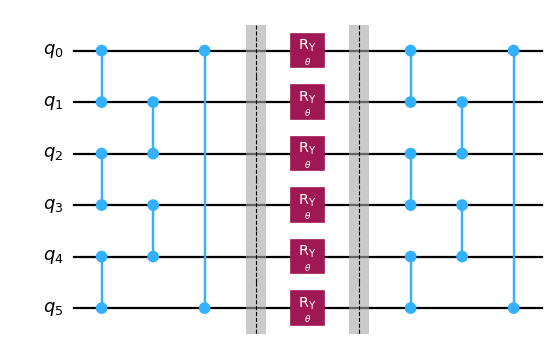

In [27]:
fig.savefig('Term Paper/O2')
fig

In [30]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt

def build_zxy_yxz_circuit(num_qubits, theta):
    """
    Constructs the variational circuit for O5 = Sum(Z_n X_{n+1} Y_{n+2} + Y_n X_{n+1} Z_{n+2}).
    
    Method: Standard Pauli Evolution Gadgets.
    Since [ZXY, YXZ] = 0, we apply the evolution for each term sequentially.
    
    Term 1: Z_i X_j Y_k
    Term 2: Y_i X_j Z_k
    """
    qc = QuantumCircuit(num_qubits, name="exp(iθ O5)")
    
    def append_pauli_evolution(i, j, k, basis_string):
        """
        Implements exp(-i * theta/2 * PauliString).
        basis_string: e.g. 'ZXY' -> Z on i, X on j, Y on k.
        """
        # 1. Basis Transformation to Z basis
        # Qubit i
        if basis_string[0] == 'X': qc.h(i)
        elif basis_string[0] == 'Y': 
            qc.rx(1.57079632679, i) # Rx(pi/2) maps Y -> Z
        
        # Qubit j
        if basis_string[1] == 'X': qc.h(j)
        elif basis_string[1] == 'Y': qc.rx(1.57079632679, j)
            
        # Qubit k
        if basis_string[2] == 'X': qc.h(k)
        elif basis_string[2] == 'Y': qc.rx(1.57079632679, k)
            
        # 2. Compute Parity (CNOT Ladder)
        qc.cx(i, j)
        qc.cx(j, k)
        
        # 3. Rotation on last qubit
        qc.rz(theta, k)
        
        # 4. Uncompute Parity
        qc.cx(j, k)
        qc.cx(i, j)
        
        # 5. Inverse Basis Transformation
        # Qubit k
        if basis_string[2] == 'X': qc.h(k)
        elif basis_string[2] == 'Y': qc.rx(-1.57079632679, k) # Inverse
        
        # Qubit j
        if basis_string[1] == 'X': qc.h(j)
        elif basis_string[1] == 'Y': qc.rx(-1.57079632679, j)
            
        # Qubit i
        if basis_string[0] == 'X': qc.h(i)
        elif basis_string[0] == 'Y': qc.rx(-1.57079632679, i)

    def append_block(i, j, k):
        # Apply ZXY
        append_pauli_evolution(i, j, k, 'ZXY')
        # Apply YXZ
        append_pauli_evolution(i, j, k, 'YXZ')

    # --- 3-Layer Trotterization (Ensuring no overlap in each layer) ---
    
    # Layer 0: 0, 3, 6...
    for n in range(0, num_qubits - 2, 3):
        append_block(n, n+1, n+2)
        
    qc.barrier()
    
    # Layer 1: 1, 4, 7...
    for n in range(1, num_qubits - 2, 3):
        append_block(n, n+1, n+2)
    # Boundary Check for Layer 1
    if num_qubits > 2:
        # Wraps L-2, L-1, 0
        append_block(num_qubits-2, num_qubits-1, 0)
        
    qc.barrier()
    
    # Layer 2: 2, 5, 8...
    for n in range(2, num_qubits - 2, 3):
        append_block(n, n+1, n+2)
    # Boundary Check for Layer 2
    if num_qubits > 2:
        # Wraps L-1, 0, 1
        append_block(num_qubits-1, 0, 1)

    return qc

# --- Visualization ---
L_viz = 6
theta_param = Parameter(r'$\theta$')
qc_viz = build_zxy_yxz_circuit(L_viz, theta_param)

print("Generating rigorous circuit diagram for O5 (ZXY + YXZ)...")
fig = qc_viz.draw('mpl', style='iqp', scale=0.6)

Generating rigorous circuit diagram for O5 (ZXY + YXZ)...


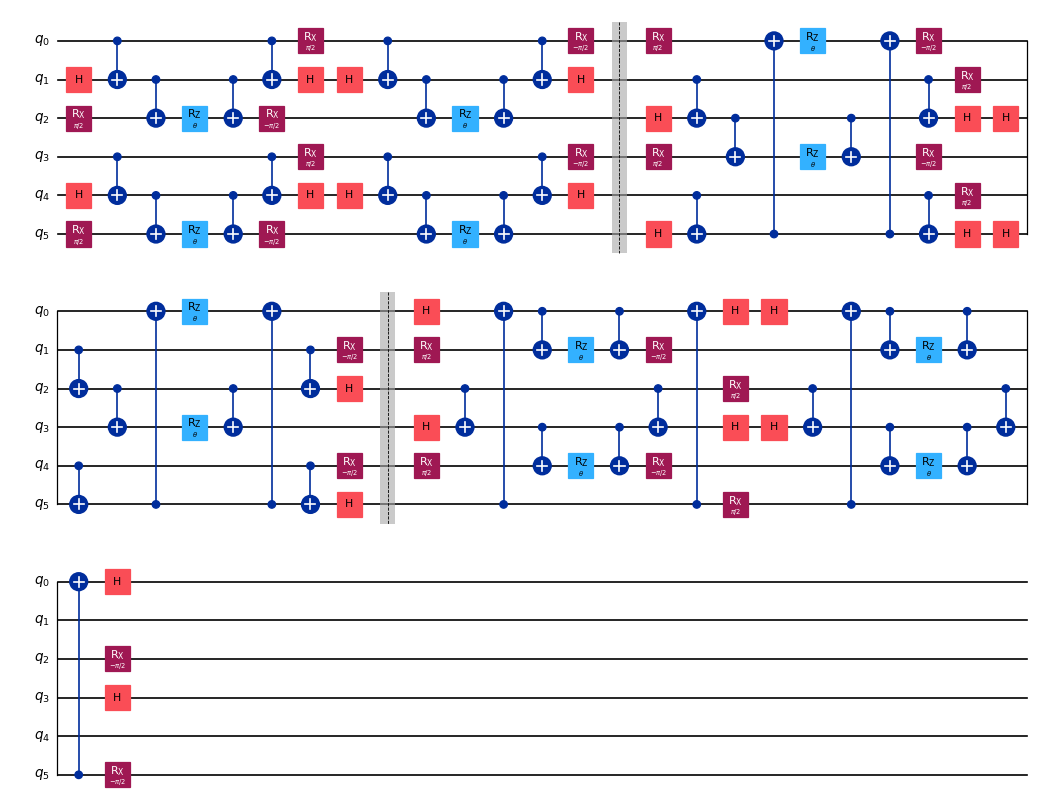

In [31]:
fig.savefig('Term Paper/O5')
fig

In [15]:
from qiskit.quantum_info import SparsePauliOp

def get_1d_ising_hamiltonian(num_qubits, gx, gz, pbc=True):
    """
    Constructs the 1D Ising Field Theory Hamiltonian.
    H = - Sum( Z_n Z_{n+1} + gx * X_n + gz * Z_n )
    
    Args:
        num_qubits (int): Lattice size L.
        gx (float): Transverse field strength.
        gz (float): Longitudinal field strength.
        pbc (bool): If True, includes Z_{L-1}Z_0 term (Periodic BC).
                    For ADAPT-VQE wavepacket prep, use pbc=True.
                    For scattering dynamics on hardware, use pbc=False.
                    
    Returns:
        SparsePauliOp: The Hamiltonian operator.
    """
    L = num_qubits
    terms = []
    
    # Helper to create SparsePauliOp with correct Endianness
    # (String index 0 -> Qubit L-1)
    def create_term(ops, coeff):
        pauli = ["I"] * L
        for idx, p in ops.items():
            # Map spatial index 'idx' to string index
            string_idx = L - 1 - idx
            pauli[string_idx] = p
        return SparsePauliOp("".join(pauli), coeffs=[coeff])

    # --- Interaction Terms (Z_n Z_{n+1}) ---
    # The minus sign from the global Hamiltonian definition is applied here
    limit = L if pbc else L - 1
    for n in range(limit):
        n_next = (n + 1) % L
        terms.append(create_term({n: "Z", n_next: "Z"}, -1.0))

    # --- Transverse Field (g_x X_n) ---
    for n in range(L):
        terms.append(create_term({n: "X"}, -1.0 * gx))

    # --- Longitudinal Field (g_z Z_n) ---
    for n in range(L):
        terms.append(create_term({n: "Z"}, -1.0 * gz))

    # Combine all terms
    H = sum(terms).simplify()
    return H

# --- Parameters from Paper (Sec III) ---
# "Our quantum simulations use gx = 1.25 and gz = 0.15" [cite: 167]
GX = 1.25
GZ = 0.15
L_SIM = 21 # Using 21 as established for our code

H_ising = get_1d_ising_hamiltonian(L_SIM, GX, GZ, pbc=True)

print(f"Hamiltonian constructed for L={L_SIM}, gx={GX}, gz={GZ}")
print(f"Total Pauli terms: {len(H_ising)}")
# Should be L (interaction) + L (X) + L (Z) = 63 terms for L=21

Hamiltonian constructed for L=21, gx=1.25, gz=0.15
Total Pauli terms: 63


In [16]:
from qiskit_aer.primitives import Estimator
from scipy.optimize import minimize_scalar

class EnergyAdaptiveVQE:
    def __init__(self, initial_circuit, operator_pool_funcs, hamiltonian, estimator):
        """
        initial_circuit: The quantum circuit preparing |W(k0)>
        operator_pool_funcs: List of functions [build_O1, build_O2...] that take (L, theta)
        hamiltonian: SparsePauliOp
        estimator: Qiskit Estimator primitive
        """
        self.ansatz = initial_circuit.copy()
        self.pool = operator_pool_funcs
        self.H = hamiltonian
        self.estimator = estimator
        self.L = initial_circuit.num_qubits
        
        # History tracking
        self.op_indices = [] # Which operator was chosen at each step
        self.parameters = [] # The optimized theta for that step
        self.energies = []   # Energy history

    def step(self):
        """Performs one step of the Greedy Energy-Selection ADAPT-VQE"""
        
        best_energy = float('inf')
        best_op_idx = -1
        best_theta = 0.0
        
        print(f"--- Starting ADAPT Step {len(self.op_indices) + 1} ---")
        
        # Try every operator in the pool
        for i, op_func in enumerate(self.pool):
            
            # 1. Define a temporary ansatz with this operator appended
            # We need a fresh parameter for this trial
            trial_theta = Parameter(f'θ_trial')
            
            # Construct the specific circuit for this operator
            op_circuit = op_func(self.L, trial_theta)
            
            # Compose: Current Ansatz + New Operator
            trial_ansatz = self.ansatz.compose(op_circuit)
            
            # 2. Optimize theta to minimize energy
            def objective(theta_val):
                bound_circuit = trial_ansatz.assign_parameters({trial_theta: theta_val})
                job = self.estimator.run(bound_circuit, self.H)
                return job.result().values[0]

            # Run Scalar Optimization
            # We search in a reasonable range, e.g., [-pi, pi]
            # Method 'Bounded' is good for scalar minimization
            from scipy.optimize import minimize_scalar
            res = minimize_scalar(objective, bounds=(-np.pi, np.pi), method='bounded')
            
            current_min_E = res.fun
            print(f"  Operator O{i+1}: Min E = {current_min_E:.6f} at θ = {res.x:.6f}")
            
            # 3. Comparison
            if current_min_E < best_energy:
                best_energy = current_min_E
                best_op_idx = i
                best_theta = res.x

        # 4. Selection & Update
        print(f">>> Selected Operator O{best_op_idx+1} with E={best_energy:.6f}")
        
        # Permanently append the winner to the ansatz with the FIXED parameter
        winner_func = self.pool[best_op_idx]
        # Note: We assign the parameter immediately to fix it as a number
        # This prevents parameter accumulation issues in Qiskit
        op_circuit_fixed = winner_func(self.L, best_theta)
        
        # Update ansatz
        # Note: compose adds to the end (mathematically U_new * U_old |0>)
        # Wait, standard convention is |psi> = U_k ... U_1 |init>.
        # Qiskit compose: qc.compose(new) -> new is applied AFTER qc.
        # So yes, compose is correct.
        self.ansatz = self.ansatz.compose(op_circuit_fixed)
        
        self.op_indices.append(best_op_idx)
        self.parameters.append(best_theta)
        self.energies.append(best_energy)
        
        return best_energy

# --- How to Run ---
# We assume 'wk0_circuit', 'H_ising', and the build functions (build_global_y_circuit etc) are defined.

# 1. Setup List of Circuit Builders
# Important: Ensure the order matches the pool indices (0=O1, 1=O2...)
operator_funcs = [
    build_global_y_circuit,      # O1
    build_zyz_circuit,           # O2
    build_yz_zy_circuit,         # O3 (Fig 7a logic)
    build_yx_xy_circuit_optimized,         # O4 (Fig 7b / sandwich logic)
    build_zxy_yxz_circuit        # O5 (Fig 7d / Pauli logic)
]

# 2. Initialize Estimator
estimator = Estimator() 

# 3. Initialize VQE
vqe = EnergyAdaptiveVQE(wk0_circuit, operator_funcs, H_ising, estimator)

# 4. Run Loop (e.g., 7 steps as per paper)
for step in range(7):
    vqe.step()

print("\nFinal Operator Ordering:", [f"O{i+1}" for i in vqe.op_indices])
print("Final Parameters:", vqe.parameters)

--- Starting ADAPT Step 1 ---
  Operator O1: Min E = -28.149707 at θ = 0.744095
  Operator O2: Min E = -22.879102 at θ = 0.340194
  Operator O3: Min E = -24.876270 at θ = 0.209944
  Operator O4: Min E = -12.714355 at θ = 1.575446
  Operator O5: Min E = -20.076953 at θ = -3.075639
>>> Selected Operator O1 with E=-28.149707
--- Starting ADAPT Step 2 ---
  Operator O1: Min E = -28.371094 at θ = -0.054058
  Operator O2: Min E = -28.793457 at θ = -0.100985
  Operator O3: Min E = -12.944824 at θ = -1.615656
  Operator O4: Min E = -28.391016 at θ = -0.029807
  Operator O5: Min E = -28.250098 at θ = 0.013217
>>> Selected Operator O2 with E=-28.793457
--- Starting ADAPT Step 3 ---
  Operator O1: Min E = -28.956641 at θ = 0.072525
  Operator O2: Min E = -28.900684 at θ = -0.045199
  Operator O3: Min E = -12.216699 at θ = 1.562628
  Operator O4: Min E = -28.466797 at θ = -0.069707
  Operator O5: Min E = -28.779297 at θ = -0.023855
>>> Selected Operator O1 with E=-28.956641
--- Starting ADAPT Step

Note: The codes below this were not possible to be run on this laptop, hence we ran it on a machine with better specs. The results obtained are mostly negative and have been analysed in the term paper. Still the codes have been copy pasted below for completeness. Also the below mentioned codes are AI optimised.

In [ ]:
import numpy as np
import gc
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector
from scipy.optimize import minimize_scalar
from qiskit.circuit import Parameter

# ==============================================================================
# 1. EXACT STATE PREPARATION (Optimized)
# ==============================================================================

def get_exact_w_statevector(L, k0, sigma):
    """
    Generates the exact 2^L statevector for |W(k0)> mathematically.
    """
    print(f"  > Allocating memory for L={L} statevector (~{2**L * 16 / 1e9:.2f} GB)...")
    x0 = (L - 1) / 2.0
    n_grid = np.arange(L)
    
    # Coefficients and Phases
    c_n = np.exp(- (n_grid - x0)**2 / (4 * (1/sigma)**2))
    phi_n = k0 * (n_grid - x0)
    coeffs = c_n * np.exp(1j * phi_n)
    coeffs /= np.linalg.norm(coeffs)
    
    # Create full vector
    full_state = np.zeros(2**L, dtype=complex)
    for n in range(L):
        full_state[1 << n] = coeffs[n]
        
    return full_state

# ==============================================================================
# 2. HAMILTONIAN & UTILS
# ==============================================================================

def pauli_term(L, ops):
    pauli = ["I"] * L
    for idx, p in ops.items():
        pauli[L - 1 - idx] = p
    return SparsePauliOp("".join(pauli), coeffs=[1.0])

def get_hamiltonian(L, gx, gz):
    terms = []
    for n in range(L):
        # H = -Sum(ZZ + gx*X + gz*Z)
        terms.append(pauli_term(L, {n:"Z", (n+1)%L:"Z"}).simplify() * -1.0)
        terms.append(pauli_term(L, {n:"X"}).simplify() * -gx)
        terms.append(pauli_term(L, {n:"Z"}).simplify() * -gz)
    return sum(terms).simplify()

# ==============================================================================
# 3. CIRCUIT BUILDERS (Standard)
# ==============================================================================

def build_O1_circuit(num_qubits, theta):
    qc = QuantumCircuit(num_qubits)
    for n in range(num_qubits): qc.ry(theta, n)
    return qc

def build_O2_circuit(num_qubits, theta):
    qc = QuantumCircuit(num_qubits)
    for i in range(0, num_qubits - 1, 2): qc.cz(i, i+1)
    for i in range(1, num_qubits - 1, 2): qc.cz(i, i+1)
    qc.cz(num_qubits - 1, 0)
    for i in range(num_qubits): qc.ry(theta, i)
    for i in range(0, num_qubits - 1, 2): qc.cz(i, i+1)
    for i in range(1, num_qubits - 1, 2): qc.cz(i, i+1)
    qc.cz(num_qubits - 1, 0)
    return qc

def build_O3_circuit(num_qubits, theta):
    qc = QuantumCircuit(num_qubits)
    def append_block(i, j):
        qc.s(j); qc.cz(i, j); qc.ry(theta, i); qc.rx(-theta, j); qc.cz(i, j); qc.sdg(j)
    for n in range(0, num_qubits - 1, 2): append_block(n, n+1)
    for n in range(1, num_qubits - 1, 2): append_block(n, n+1)
    append_block(num_qubits - 1, 0)
    return qc

def build_O4_circuit(num_qubits, theta):
    qc = QuantumCircuit(num_qubits)
    def append_block(i, j):
        qc.h(i); qc.h(j); qc.s(j); qc.cz(i, j); qc.ry(theta, i); qc.rx(-theta, j); qc.cz(i, j); qc.sdg(j); qc.h(i); qc.h(j)
    for n in range(0, num_qubits - 1, 2): append_block(n, n+1)
    for n in range(1, num_qubits - 1, 2): append_block(n, n+1)
    append_block(num_qubits - 1, 0)
    return qc

def build_O5_circuit(num_qubits, theta):
    qc = QuantumCircuit(num_qubits)
    def append_pauli(i, j, k, pstr):
        if pstr[0]=='X': qc.h(i)
        elif pstr[0]=='Y': qc.rx(np.pi/2, i)
        if pstr[1]=='X': qc.h(j)
        elif pstr[1]=='Y': qc.rx(np.pi/2, j)
        if pstr[2]=='X': qc.h(k)
        elif pstr[2]=='Y': qc.rx(np.pi/2, k)
        qc.cx(i, j); qc.cx(j, k); qc.rz(theta, k); qc.cx(j, k); qc.cx(i, j)
        if pstr[2]=='X': qc.h(k)
        elif pstr[2]=='Y': qc.rx(-np.pi/2, k)
        if pstr[1]=='X': qc.h(j)
        elif pstr[1]=='Y': qc.rx(-np.pi/2, j)
        if pstr[0]=='X': qc.h(i)
        elif pstr[0]=='Y': qc.rx(-np.pi/2, i)
    def append_block(i, j, k):
        append_pauli(i, j, k, 'ZXY'); append_pauli(i, j, k, 'YXZ')
    for n in range(0, num_qubits - 2, 3): append_block(n, n+1, n+2)
    for n in range(1, num_qubits - 2, 3): append_block(n, n+1, n+2)
    if num_qubits > 2: append_block(num_qubits-2, num_qubits-1, 0)
    for n in range(2, num_qubits - 2, 3): append_block(n, n+1, n+2)
    if num_qubits > 2: append_block(num_qubits-1, 0, 1)
    return qc

# ==============================================================================
# 4. MEMORY-OPTIMIZED BENCHMARK EXECUTION
# ==============================================================================

def run_benchmark_L28_optimized():
    # Parameters
    L = 28
    K0 = 0.36 * np.pi
    SIGMA = 0.13
    GX = 1.25
    GZ = 0.15
    
    print(f"--- Starting L={L} Benchmark (Optimized Memory) ---")
    
    # 1. Create Statevector object directly (Avoids Circuit Instruction overhead)
    # This creates ONE copy of the 4GB vector.
    psi_np = get_exact_w_statevector(L, K0, SIGMA)
    current_state = Statevector(psi_np)
    
    # Free the numpy array immediately
    del psi_np
    gc.collect()
    print("  > Initial Statevector loaded.")
    
    # 2. Setup Operators
    H = get_hamiltonian(L, GX, GZ)
    pool_funcs = [build_O1_circuit, build_O2_circuit, build_O3_circuit, build_O4_circuit, build_O5_circuit]
    op_labels = ["O1 (Y)", "O2 (ZYZ)", "O3 (YZ+ZY)", "O4 (YX+XY)", "O5 (ZXY+YXZ)"]
    
    print(f"  > Hamiltonian built. Starting VQE Loop...")
    
    # 3. The Loop
    for step in range(1, 4): 
        best_E = float('inf')
        best_op_idx = -1
        best_theta = 0.0
        
        print(f"\nStep {step}: Scanning pool...")
        
        for i, builder in enumerate(pool_funcs):
            # Create the small parameterized circuit for this operator
            theta_p = Parameter('th')
            op_circ = builder(L, theta_p)
            
            def objective(x):
                # Bind the parameter to a specific float value
                bound_circ = op_circ.assign_parameters({theta_p: x})
                
                # Evolve the CURRENT state by this operator
                # This creates a temporary new statevector (Trial State)
                trial_state = current_state.evolve(bound_circ)
                
                # Compute Energy
                energy = trial_state.expectation_value(H).real
                
                # CRITICAL: Force delete the trial state to free 4GB RAM
                del trial_state
                
                return energy
            
            # Optimization
            # Note: 'x' passed to objective is a float scalar here
            res = minimize_scalar(objective, bounds=(-np.pi, np.pi), method='bounded')
            
            print(f"  {op_labels[i]}: E={res.fun:.5f} | th={res.x:.4f}")
            
            # Clean up
            gc.collect()
            
            if res.fun < best_E:
                best_E = res.fun
                best_op_idx = i
                best_theta = res.x
        
        print(f">>> Selected: {op_labels[best_op_idx]} | theta={best_theta:.4f}")
        
        # PERMANENT UPDATE
        # Apply the winner to the current state statevector permanently
        # This replaces the old 'current_state' with the new one
        winner_builder = pool_funcs[best_op_idx]
        winner_circ = winner_builder(L, best_theta)
        
        current_state = current_state.evolve(winner_circ)
        
        # Force garbage collection to ensure old state is gone
        gc.collect()

if __name__ == "__main__":
    run_benchmark_L28_optimized()

In [ ]:
import numpy as np
import gc
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit import Parameter

# ==============================================================================
# 1. EXACT STATE PREPARATION (Mathematical Init)
# ==============================================================================

def get_exact_w_statevector(L, k0, sigma):
    """
    Generates the exact 2^L statevector for |W(k0)> mathematically.
    Bypasses hardware constraints to allow L=28 simulation.
    """
    x0 = (L - 1) / 2.0
    n_grid = np.arange(L)
    
    # Coefficients and Phases
    c_n = np.exp(- (n_grid - x0)**2 / (4 * (1/sigma)**2))
    phi_n = k0 * (n_grid - x0)
    coeffs = c_n * np.exp(1j * phi_n)
    coeffs /= np.linalg.norm(coeffs)
    
    # Map to Hilbert Space (2^28 complex128s = ~4GB RAM)
    full_state = np.zeros(2**L, dtype=complex)
    for n in range(L):
        full_state[1 << n] = coeffs[n]
        
    return full_state

# ==============================================================================
# 2. HAMILTONIAN & UTILS
# ==============================================================================

def pauli_term(L, ops):
    """Helper for Endian-corrected Pauli strings"""
    pauli = ["I"] * L
    for idx, p in ops.items():
        pauli[L - 1 - idx] = p
    return SparsePauliOp("".join(pauli), coeffs=[1.0])

def get_hamiltonian(L, gx, gz):
    """1D Ising Hamiltonian with PBC"""
    terms = []
    for n in range(L):
        # H = -Sum(ZZ + gx*X + gz*Z)
        terms.append(pauli_term(L, {n:"Z", (n+1)%L:"Z"}).simplify() * -1.0)
        terms.append(pauli_term(L, {n:"X"}).simplify() * -gx)
        terms.append(pauli_term(L, {n:"Z"}).simplify() * -gz)
    return sum(terms).simplify()

# ==============================================================================
# 3. CIRCUIT BUILDERS
# ==============================================================================

def build_O1_circuit(num_qubits, theta):
    """O1 = Sum(Y)"""
    qc = QuantumCircuit(num_qubits)
    for n in range(num_qubits):
        qc.ry(theta, n)
    return qc

def build_O2_circuit(num_qubits, theta):
    """O2 = Sum(ZYZ)"""
    qc = QuantumCircuit(num_qubits)
    # Pre-entangle
    for i in range(0, num_qubits - 1, 2): qc.cz(i, i+1)
    for i in range(1, num_qubits - 1, 2): qc.cz(i, i+1)
    qc.cz(num_qubits - 1, 0)
    # Rotate
    for i in range(num_qubits): qc.ry(theta, i)
    # Post-entangle
    for i in range(0, num_qubits - 1, 2): qc.cz(i, i+1)
    for i in range(1, num_qubits - 1, 2): qc.cz(i, i+1)
    qc.cz(num_qubits - 1, 0)
    return qc

def build_O3_circuit(num_qubits, theta):
    """O3 = Sum(YZ + ZY)"""
    qc = QuantumCircuit(num_qubits)
    def append_block(i, j):
        qc.s(j); qc.cz(i, j)
        qc.ry(theta, i); qc.rx(-theta, j)
        qc.cz(i, j); qc.sdg(j)
    
    for n in range(0, num_qubits - 1, 2): append_block(n, n+1)
    for n in range(1, num_qubits - 1, 2): append_block(n, n+1)
    append_block(num_qubits - 1, 0)
    return qc

def build_O4_circuit(num_qubits, theta):
    """O4 = Sum(YX + XY)"""
    qc = QuantumCircuit(num_qubits)
    def append_block(i, j):
        qc.h(i); qc.h(j)
        qc.s(j); qc.cz(i, j)
        qc.ry(theta, i); qc.rx(-theta, j)
        qc.cz(i, j); qc.sdg(j)
        qc.h(i); qc.h(j)

    for n in range(0, num_qubits - 1, 2): append_block(n, n+1)
    for n in range(1, num_qubits - 1, 2): append_block(n, n+1)
    append_block(num_qubits - 1, 0)
    return qc

def build_O5_circuit(num_qubits, theta):
    """O5 = Sum(ZXY + YXZ)"""
    qc = QuantumCircuit(num_qubits)
    def append_pauli(i, j, k, pstr):
        # Basis change
        if pstr[0] == 'X': qc.h(i)
        elif pstr[0] == 'Y': qc.rx(np.pi/2, i)
        if pstr[1] == 'X': qc.h(j)
        elif pstr[1] == 'Y': qc.rx(np.pi/2, j)
        if pstr[2] == 'X': qc.h(k)
        elif pstr[2] == 'Y': qc.rx(np.pi/2, k)
        
        # Evolution
        qc.cx(i, j); qc.cx(j, k)
        qc.rz(theta, k)
        qc.cx(j, k); qc.cx(i, j)
        
        # Inverse basis
        if pstr[2] == 'X': qc.h(k)
        elif pstr[2] == 'Y': qc.rx(-np.pi/2, k)
        if pstr[1] == 'X': qc.h(j)
        elif pstr[1] == 'Y': qc.rx(-np.pi/2, j)
        if pstr[0] == 'X': qc.h(i)
        elif pstr[0] == 'Y': qc.rx(-np.pi/2, i)

    def append_block(i, j, k):
        append_pauli(i, j, k, 'ZXY')
        append_pauli(i, j, k, 'YXZ')

    for n in range(0, num_qubits - 2, 3): append_block(n, n+1, n+2)
    for n in range(1, num_qubits - 2, 3): append_block(n, n+1, n+2)
    if num_qubits > 2: append_block(num_qubits-2, num_qubits-1, 0)
    for n in range(2, num_qubits - 2, 3): append_block(n, n+1, n+2)
    if num_qubits > 2: append_block(num_qubits-1, 0, 1)
    return qc

# ==============================================================================
# 4. FULL BENCHMARK EXECUTION (Analytical Method)
# ==============================================================================

def run_full_benchmark_L28():
    # Configuration matches Table VII Caption
    L = 28
    K0 = 0.36 * np.pi
    SIGMA = 0.13
    GX = 1.25
    GZ = 0.15
    
    print(f"--- Starting Full L={L} Benchmark (8 Steps) ---")
    print(f"Target Sequence (Table VII): O1 -> O3 -> O1 -> O5 -> O3 -> O3 -> O1 -> O2")
    
    # 1. Create Initial Statevector
    print("Generating Statevector...")
    psi_np = get_exact_w_statevector(L, K0, SIGMA)
    
    # Initialize current_state properly
    current_state = Statevector(psi_np)
    
    # Free numpy memory immediately
    del psi_np
    gc.collect()
    
    # 2. Setup Physics
    H = get_hamiltonian(L, GX, GZ)
    
    # Pool Configuration
    pool_funcs = [
        build_O1_circuit, 
        build_O2_circuit, 
        build_O3_circuit, 
        build_O4_circuit, 
        build_O5_circuit
    ]
    op_labels = ["O1 (Y)", "O2 (ZYZ)", "O3 (YZ+ZY)", "O4 (YX+XY)", "O5 (ZXY..YXZ)"]
    
    history = []
    
    # 3. The Loop (8 Steps)
    for step in range(1, 9): 
        best_E = float('inf')
        best_op_idx = -1
        best_theta = 0.0
        
        # Current energy (E0) is the same for all trials (theta=0)
        E_current = current_state.expectation_value(H).real
        print(f"\nStep {step}: Start E={E_current:.5f} | Scanning pool...")
        
        for i, builder in enumerate(pool_funcs):
            # Analytical Minimization Method: E(theta) = A + B*cos(theta) + C*sin(theta)
            # We need 3 points: 0, pi/2, -pi/2
            
            # 1. Measure at +pi/2
            circ_p = builder(L, np.pi/2)
            psi_p = current_state.evolve(circ_p)
            E_plus = psi_p.expectation_value(H).real
            del psi_p
            
            # 2. Measure at -pi/2
            circ_m = builder(L, -np.pi/2)
            psi_m = current_state.evolve(circ_m)
            E_minus = psi_m.expectation_value(H).real
            del psi_m
            
            # Garbage collect heavy vectors
            gc.collect()
            
            # 3. Solve Landscape
            C = (E_plus - E_minus) / 2.0
            A = (E_plus + E_minus) / 2.0
            B = E_current - A
            
            # Theoretical minimum
            min_E_val = A - np.sqrt(B**2 + C**2)
            
            # Find theta_opt
            theta_opt = np.arctan2(C, B) + np.pi
            # Wrap to [-pi, pi]
            theta_opt = (theta_opt + np.pi) % (2 * np.pi) - np.pi
            
            if min_E_val < best_E:
                best_E = min_E_val
                best_op_idx = i
                best_theta = theta_opt
        
        print(f">>> Winner: {op_labels[best_op_idx]} | E={best_E:.5f} | θ={best_theta:.4f}")
        
        # Permanent Update
        winner_builder = pool_funcs[best_op_idx]
        winner_circ = winner_builder(L, best_theta)
        current_state = current_state.evolve(winner_circ)
        history.append((op_labels[best_op_idx], best_theta))
        gc.collect()

    # --- Final Report ---
    print("\n--- Benchmark Complete ---")
    print(f"{'Step':<5} | {'Operator':<15} | {'Theta (Rad)':<10}")
    for i, (op, th) in enumerate(history):
        print(f"{i+1:<5} | {op:<15} | {th:.4f}")

if __name__ == "__main__":
    run_full_benchmark_L28()